<a href="https://colab.research.google.com/github/bmurmann/US_Japan_Semiconductor_Workshop/blob/main/Day%201%20-%201100%20-%20Teaching%20using%20OS/demo1/SKY130_Track_and_Hold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SKY130 Track and Hold Circuit

# Tool setup

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

CONDA_PREFIX = os.environ.get('CONDA_PREFIX', None)
if not CONDA_PREFIX:
  import condacolab
  CONDA_PREFIX = condacolab.PREFIX

In [38]:
%%writefile environment.yml
channels:
  - litex-hub
dependencies:
  - open_pdks.sky130a
  - ngspice

Overwriting environment.yml


In [39]:
!mamba env update -n base -f environment.yml

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache
[+] 0.0s
[+] 0.1s
litex-hub/linux-64  ⣾  
litex-hub/noarch    ⣾  [+] 0.2s
litex-hub/linux-64  ⣾  
litex-hub/noarch    ⣾  litex-hub/noarch                                              No change
[+] 0.3s
litex-hub/linux-64  ⣾  [+] 0.4s
litex-hub/linux-64  ⣾  [+] 0.5s
litex-hub/linux-64  ⣾  [+] 0.6s
litex-hub/linux-64  ⣾  [+] 0.7s
litex-hub/linux-64  ⣾  [+] 0.8s
litex-hub/linux-64  ⣾  [+] 0.9s
litex-hub/linux-64  ⣾  [+] 1.0s
litex-hub/linux-64  ⣾  [+] 1.1s
litex-hub/linux-64  ⣾  [+] 1.2s
litex-hub/linux-64  ⣾  [+] 1.3s
litex-hub/linux-64  ⣾  [+] 1.4s
litex-hub/linux-64  ⣾  [+] 1.5s
litex-hub/linux-64  ⣾  [+] 1.6s
litex-hub/linux-64  ⣾  [+] 1.7s
litex-hub/linux-64  ⣾  litex-hub/linux-64                                            No change


Looking for: ['open_pdks.sky130a', 'ngspice']



  Pinned packages:

  - python 3.10.*
  - python_abi 3.10.* 

# Simulation

In [40]:
%%writefile .spiceinit
* ngspice initialization for sky130
* assert BSIM compatibility mode with "nf" vs. "W"
set ngbehavior=hsa
* "nomodcheck" speeds up loading time
set ng_nomodcheck

Overwriting .spiceinit


In [41]:
%%writefile netlist.spice
* Track-and-hold circuit using single NMOS
.lib "/usr/local/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice" tt
x1 in clk out 0 sky130_fd_pr__nfet_01v8_lvt w=5 l=0.15
cl out 0 100f
vin  in 0 sin (0.4 0.2 {fin})
vclk clk 0 pulse (1.2 0 0 100p 100p {per/2} {per})
.param nfft=64 fclk=10Meg per=1/fclk cycles=3 fin=fclk*cycles/nfft

Overwriting netlist.spice


In [42]:
%%writefile sim1.spice
* First simulation "continuous time"
.inc netlist.spice
.option method=gear
.tran 1n {per*(nfft+3)}
.control
set wr_singlescale
set wr_vecnames
run
wrdata output1.txt out
.endc

Overwriting sim1.spice


In [43]:
%%writefile sim2.spice
* Second simulation "discrete time"
.inc netlist.spice
.option method=gear reltol=1e-6 interp
.tran {per} {per*(nfft+3)} {0.25*per}
.control
set wr_singlescale
set wr_vecnames
run
wrdata output2.txt out
.endc

Overwriting sim2.spice


In [44]:
!ngspice -b sim1.spice


Note: Compatibility modes selected: hs a



Circuit: * first simulation "continuous time"

option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
in                                         0.4
clk                                        1.2
out                                        0.4
vclk#branch                                  0
vin#branch                            -8.2e-13


No. of Data Rows : 8203
Note: Simulation executed from .control section 


In [45]:
!ngspice -b sim2.spice


Note: Compatibility modes selected: hs a



Circuit: * second simulation "discrete time"

option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000



Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
in                                         0.4
clk                                        1.2
out                                        0.4
vclk#branch                                  0
vin#branch                            -8.2e-13


No. of Data Rows : 67
Note: Simulation executed from .control section 


In [46]:
df1 = pd.read_csv("output1.txt", sep='\s+')
df1

,time,out
0,0.000000e+00,0.400000
1,1.000000e-12,0.399620
2,2.000000e-12,0.399246
3,4.000000e-12,0.398509
4,8.000000e-12,0.397080
...,...,...
8198,6.696123e-06,0.552783
8199,6.697123e-06,0.553160
8200,6.698123e-06,0.553535
8201,6.699123e-06,0.553909


In [47]:
df2 = pd.read_csv("output2.txt", sep='\s+')
df2

,time,out
0,1.250000e-07,0.437412
1,2.250000e-07,0.491383
2,3.250000e-07,0.535485
3,4.250000e-07,0.566086
4,5.250000e-07,0.580838
...,...,...
62,6.325000e-06,0.319125
63,6.425000e-06,0.378260
64,6.525000e-06,0.437411
65,6.625000e-06,0.491383


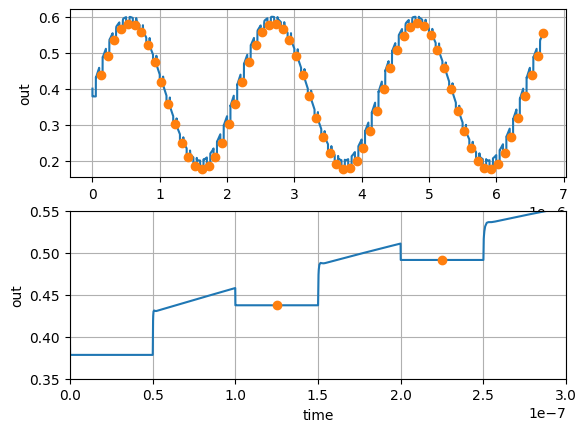

In [48]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(df1['time'], df1['out'])
ax1.plot(df2['time'], df2['out'], "o")
ax1.grid()
ax1.set_ylabel("out")

ax2.plot(df1['time'], df1['out'])
ax2.plot(df2['time'], df2['out'], "o")
ax2.grid()
ax2.set_xlabel("time")
ax2.set_ylabel("out")
ax2.set_xlim([0, 0.3e-6])
ax2.set_ylim([0.35, 0.55]);

In [49]:
# Check periodicity/staedy state by comparing the last sample of the FFT window with one right before the window
nfft=64
y = df2['out'].values
# Remove last point since it's off the sampling grid
y = y[:-1]
print(len(y))
relative_error = (y[-1]-y[-1-nfft])/y[-1]
print(relative_error)
y = y[-nfft:]
print(len(y))

66
-2.604894438487237e-07
64


In [50]:
spec = np.fft.rfft(y)
spec_dbv = 20*np.log10(np.abs(spec)/(nfft/2))
print(spec_dbv)

[  -2.41971802 -106.30818086 -105.95105379  -13.82639221 -112.17672553
 -107.39591335  -73.72039558 -110.11496738 -108.45377309  -74.83654876
 -107.4057389  -114.5941762   -82.02087659 -109.60468577 -112.22368753
  -86.28318076 -115.30789163 -106.89363493  -95.19152507 -110.72340527
 -112.52741101 -101.17427045 -110.54910507 -117.84736346 -105.5455865
 -112.31043541 -114.28041523 -117.02034315 -106.85570812 -117.36385848
 -117.83547091 -107.10061937 -126.24496304]


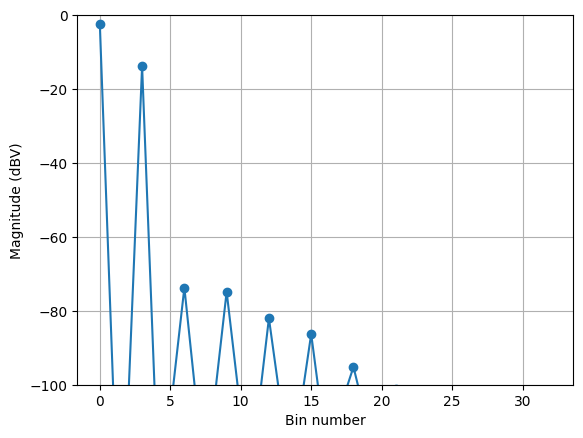

In [51]:
plt.plot(spec_dbv, "-o")
plt.grid()
plt.xlabel("Bin number")
plt.ylabel("Magnitude (dBV)");
plt.ylim([-100, 0]);

In [52]:
hd3_db = spec_dbv[3]-spec_dbv[6]
print(hd3_db)

59.89400337173039
